<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span><ul class="toc-item"><li><span><a href="#Обработка-входных-данных" data-toc-modified-id="Обработка-входных-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обработка входных данных</a></span></li><li><span><a href="#Функция-sMAPE" data-toc-modified-id="Функция-sMAPE-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Функция sMAPE</a></span></li><li><span><a href="#Обучение-различных-моделей-и-выбор-наилучшей" data-toc-modified-id="Обучение-различных-моделей-и-выбор-наилучшей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение различных моделей и выбор наилучшей</a></span></li><li><span><a href="#Проверка-результатов-на-тестовой-выборке" data-toc-modified-id="Проверка-результатов-на-тестовой-выборке-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Проверка результатов на тестовой выборке</a></span></li></ul></li></ul></div>

# Восстановление золота из руды

Наша задача - подготовить модель для золотодобывающей компании-производителя.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Будем использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Для того, чтобы достигнуть нашей цели, мы предпримем следующие шаги:
1. Изучим данные выборок и проверим правильность расчета эффективности обогащения при помощи метрики МАЕ.
2. Предобработаем и очистим данные.
3. Оценим динамику изменения концентрации металлов на различных этапах очистки.
4. Сравним распределение размеров гранул сырья на обучающей и тестовой выборках.
5. Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.
6. Построим и обучим различные модели и оценим качество при помощи метрики sMAPE.

In [1]:
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

## Подготовка данных

In [2]:
train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Необходимо проверить, что эффективность обогащения посчитана корректно.
Симулируем расчет эффективности обогащения на примере данных для флотации (rougher). <br>
Эффективность обогащение рассчитывается по формуле: <br>
Recovery = (C x (F - T) / (F x (C- T)), <br>
где <br>
C ("concentrate") - доля золота в концентрате (rougher.output.concentrate_au) <br>
F ("feed") - доля золота в сырье (rougher.input.feed_au) <br>
T ("tail") - доля золота в отвальных хвостах (rougher.output.tail_au)

In [3]:
train['rougher.recovery_calc'] = (train['rougher.output.concentrate_au']*
                                 (train['rougher.input.feed_au']-
                                 train['rougher.output.tail_au'])
                                 )/(train['rougher.input.feed_au']*
                                   (train['rougher.output.concentrate_au']-
                                   train['rougher.output.tail_au']))*100
  

print('MAE расчетной эффективности обогащения по сравнению с фактической равна', mean_absolute_error(train['rougher.recovery_calc'], train['rougher.output.recovery']))

MAE расчетной эффективности обогащения по сравнению с фактической равна 9.73512347450521e-15


Мы видим, что МАЕ расчетных данных по сравнению с фактическими практически равно нулю. Это означает, что фактические данные посчитаны корректно и нет необходимости пересчитывать их.

**Предобработка данных.**

В тестовой выборке (датасет test) количество столбцов не совпадает с количеством столбцов в датасете с полными данными (full). Необходимо понять, какие столбцы отсутствуют.

In [4]:
features_list = pd.DataFrame(full.columns, columns = ['features_list'])
display(features_list.query('features_list not in @test.columns'))

,features_list
1,final.output.concentrate_ag
2,final.output.concentrate_pb
3,final.output.concentrate_sol
4,final.output.concentrate_au
5,final.output.recovery
6,final.output.tail_ag
7,final.output.tail_pb
8,final.output.tail_sol
9,final.output.tail_au
14,primary_cleaner.output.concentrate_ag


Исходя из списка столбцов, отсутствующих в тестовой выборке, мы можем сделать вывод, что отсутствуют все столбцы, связанные с харакетеристиками *продукта* (output), причем на всех стадиях производства.

In [5]:
# проверим на явные дубликаты
train.duplicated().sum()
test.duplicated().sum()

0

Для улучшения работы модели нам нужно избавиться от NaN. Часть из них мы можем отбросить, а часть необходимо заменить на подходящую величину.

In [6]:
# посчитаем процентное соотношение строк с Nan к общему кол-ву строк в датасете 
cols = len(train)- train.count()
cols = pd.DataFrame(cols, index = train.columns, columns = ['num'])
cols = cols[cols['num']>0]
cols['percent'] = cols['num']/len(train)*100
cols.sort_values(by = 'percent', ascending = False)

,num,percent
secondary_cleaner.output.tail_sol,1605,11.343558
rougher.state.floatbank10_e_air,436,3.081490
rougher.input.floatbank11_xanthate,428,3.024949
primary_cleaner.output.concentrate_sol,286,2.021344
secondary_cleaner.state.floatbank2_a_air,217,1.533677
...,...,...
rougher.state.floatbank10_a_air,1,0.007068
rougher.state.floatbank10_a_level,1,0.007068
rougher.state.floatbank10_b_air,1,0.007068
rougher.state.floatbank10_b_level,1,0.007068


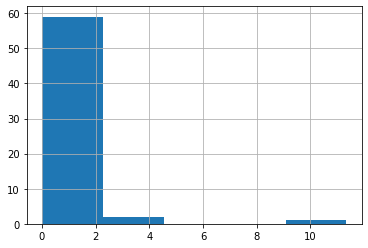

In [7]:
cols['percent'].hist(bins = 5);

По таблице и графику мы видим, что в большинстве столбцов количество Null'овых значений не превышает 2% от общего количества строк. В них можно отбросить null'овые строки без потери репрезентативности.

In [8]:
train = train.dropna(subset = cols[cols['percent']<2].index)
#попробуем заполнить оставшиеся столбцы, не повлияв на характеристики распределения
train[cols[cols['percent']>2].index].describe()

,primary_cleaner.output.concentrate_sol,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_e_air,secondary_cleaner.output.tail_sol
count,13005.000000,12775.000000,12699.000000,11801.000000
mean,10.177066,5.940906,1082.990345,6.968320
std,4.030091,1.070071,181.939965,4.147326
min,0.000000,0.000290,94.372023,0.000000
25%,7.538393,5.200964,952.856349,3.241453
50%,9.745265,5.999419,1050.066174,7.351074
75%,13.107841,6.701684,1199.760718,10.563236
max,21.810330,9.698407,1922.636637,17.976171


Оставшиеся столбцы (их всего 4) можно заполнить значениямиб равными предыдущей строке (т.к. соседние по времени объекты похожи или даже одинаковы). Это не повлияет на репрезентативность - основные статистические показатели (мин, макс, средняя, медиана) остались без изменений.

In [9]:
train[cols[cols['percent']>2].index] = train[cols[cols['percent']>2].index].ffill()
train[cols[cols['percent']>2].index].describe()

,primary_cleaner.output.concentrate_sol,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_e_air,secondary_cleaner.output.tail_sol
count,13126.000000,13126.000000,13126.000000,13126.000000
mean,10.118700,5.861146,1076.991181,6.357742
std,4.065963,1.173221,183.605512,4.346203
min,0.000000,0.000290,94.372023,0.000000
25%,7.466863,5.172327,950.473121,2.308036
50%,9.709285,5.998155,1049.754472,6.306603
75%,13.080037,6.698629,1199.577662,10.347042
max,21.810330,9.698407,1922.636637,17.976171


Судя по таблице, основные характеристики (медиана, среднее и 75% квартиль) практически не изменились, значить такая замена вполне корректна.

In [10]:
#сделаем то же самое с таблицей full
full = full.dropna(subset = cols[cols['percent']<2].index)
full[cols[cols['percent']>2].index] = full[cols[cols['percent']>2].index].fillna(full[cols[cols['percent']>2].index].median())
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18333 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                18333 non-null  object 
 1   final.output.concentrate_ag                         18333 non-null  float64
 2   final.output.concentrate_pb                         18333 non-null  float64
 3   final.output.concentrate_sol                        18333 non-null  float64
 4   final.output.concentrate_au                         18333 non-null  float64
 5   final.output.recovery                               18333 non-null  float64
 6   final.output.tail_ag                                18333 non-null  float64
 7   final.output.tail_pb                                18333 non-null  float64
 8   final.output.tail_sol                               18333 non-null  float64


In [11]:
# дополним данные в тестовой выборке столбцами с целевым признаком из полного датасета
test = pd.merge(test, full[['date', 'final.output.recovery', 'rougher.output.recovery']], how = 'left', on =['date'], copy = False)

## Анализ данных

Проанализируем, как меняется концентрация металлов (серебра, золота, свинца) на различных этапах очистки: rougher, primary_cleaner, secondary_cleaner. Это характеристика output (продукта).

In [13]:
#выделим в отдельные таблицы столбцы с этими данными
concentration_ag = full[['rougher.output.concentrate_ag',
                     'primary_cleaner.output.concentrate_ag',
                     'final.output.concentrate_ag']]
concentration_au = full[['rougher.output.concentrate_au',
                     'primary_cleaner.output.concentrate_au',
                     'final.output.concentrate_au']]
concentration_pb = full[['rougher.output.concentrate_pb',
                     'primary_cleaner.output.concentrate_pb',
                     'final.output.concentrate_pb']]

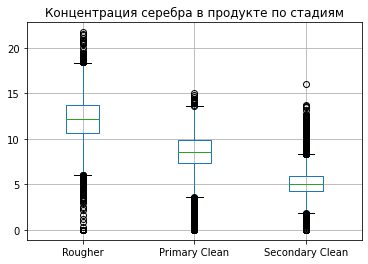

In [14]:
concentration_ag.boxplot()
plt.xticks(ticks =[1,2,3], labels = ['Rougher', 'Primary Clean', 'Secondary Clean'])
plt.title('Концентрация серебра в продукте по стадиям');

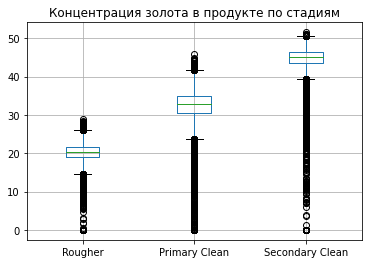

In [15]:
concentration_au.boxplot()
plt.xticks(ticks =[1,2,3], labels = ['Rougher', 'Primary Clean', 'Secondary Clean'])
plt.title('Концентрация золота в продукте по стадиям');

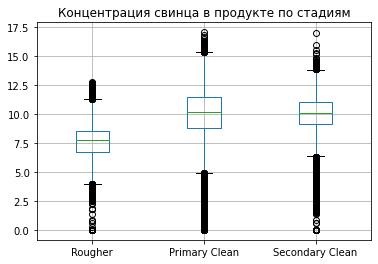

In [16]:
concentration_pb.boxplot()
plt.xticks(ticks =[1,2,3], labels = ['Rougher', 'Primary Clean', 'Secondary Clean'])
plt.title('Концентрация свинца в продукте по стадиям');

На графиках видна тенденция в поведении величины концентрации металлов в продукте, в зависимости от металла:
- концентрация золота растет с прохождением этапов обработки руды - это логично, т.к. в этом и есть смысл обработки руды - привести концентрацию золота к максимально возможной величине;
- концентрация серебра падает с прохождением этапов, что тоже логично, т.к. смысл этапов - избавление руды от примесей, в том числе от серебра;
- концентрация свинца немного растет в среднем при переходе от флотации к первичной очистке, и затем существенно не меняется (хотя диапазон значений немного сокращается в готовом продукте по сравнению с результатом первичной очистки). Возможно, это связано с технологическим процессом очистки.

Далее нам необходимо **сравнить распределение гранул сырья на обучающей и тестовой выборках.**

'Трейновая выборка'

count    13126.000000
mean        59.852918
std         21.747315
min          9.659576
25%         48.977390
50%         55.261594
75%         65.707495
max        484.967466
Name: rougher.input.feed_size, dtype: float64

'Тестовая выборка'

count    5289.000000
mean       55.951097
std        19.081758
min         0.046369
25%        43.906347
50%        50.841029
75%        62.431047
max       392.494040
Name: rougher.input.feed_size, dtype: float64

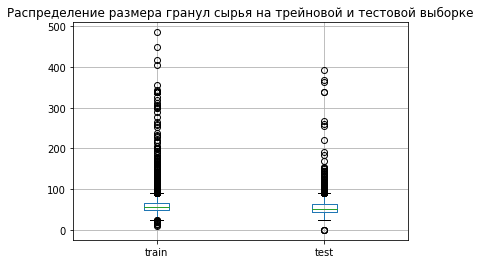

In [17]:
pd.DataFrame([train['rougher.input.feed_size'],test['rougher.input.feed_size']]).T.boxplot()
plt.xticks(ticks =[1,2], labels = ['train', 'test'])
plt.title('Распределение размера гранул сырья на трейновой и тестовой выборке');

display('Трейновая выборка', train['rougher.input.feed_size'].describe())
display("Тестовая выборка", test['rougher.input.feed_size'].describe())
         

По графику распределения видно, что в целом распределение значений на трейновой и тестовой выборках совпадает - средняя, медиана и значения 25% и 75% квартиля недалеки друг от друга. На тестовой выборке разброс значений меньше, но тенденция сохраняется. <br>
Это означает, что проблем с работой модели быть не должно.

Исследуем теперь **суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.**

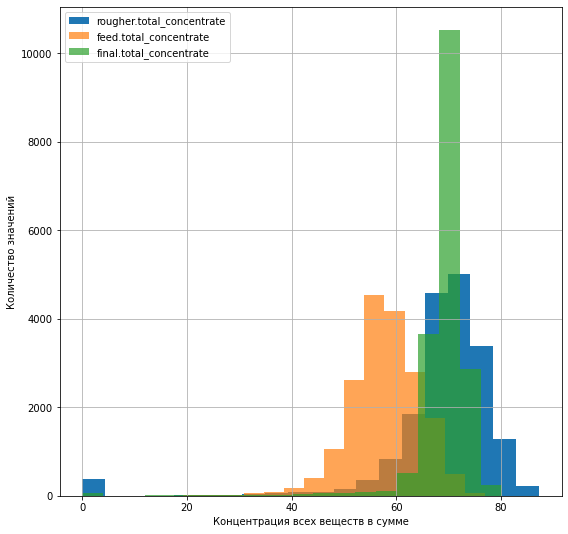

In [18]:
# создадим столбцы с суммарной концентрацией веществ

full['feed.total_concentrate'] = (full['rougher.input.feed_au'] +
                                     full['rougher.input.feed_ag']+
                                     full['rougher.input.feed_pb']+
                                     full['rougher.input.feed_sol'])

full['rougher.total_concentrate'] = (full['rougher.output.concentrate_au'] +
                                     full['rougher.output.concentrate_ag']+
                                     full['rougher.output.concentrate_pb']+
                                     full['rougher.output.concentrate_sol'])

full['final.total_concentrate'] = (full['final.output.concentrate_au'] +
                                     full['final.output.concentrate_ag']+
                                     full['final.output.concentrate_pb']+
                                     full['final.output.concentrate_sol'])

full['rougher.total_concentrate'].hist(bins = 20, alpha = 1, figsize = (9, 9), legend = True)
full['feed.total_concentrate'].hist(bins = 20, alpha = 0.7, legend = True)
full['final.total_concentrate'].hist(bins = 20, alpha = 0.7, legend = True)
plt.ylabel('Количество значений')
plt.xlabel('Концентрация всех веществ в сумме');

На гистограмме видно, что в целом значения распределены нормально, но есть большое количество нулевых или околонулевых значений. Причем больше всего таких значений на стадии флотации - "пустая" руда с минимальным количеством веществ. Следует повнимательнее изучить эти данные.

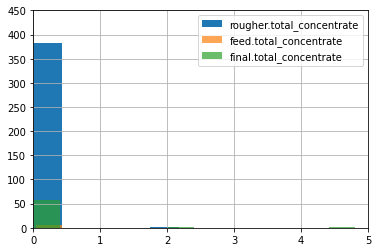

In [19]:
full['rougher.total_concentrate'].hist(bins = 200, legend = True)
full['feed.total_concentrate'].hist(bins = 200, alpha = 0.7, legend = True)
full['final.total_concentrate'].hist(bins = 200, alpha = 0.7, legend = True)
plt.xlim(0,5)
plt.ylim(0, 450);

Странным и нелогичным кажется то, что по мере прохождения стадий очистки количество "нулевых" показателей уменьшается. С точки зрения физики такое невозможно - еслии кол-во вещества было равно 0 на начальной стадии, то после очистки от примесей количество вещества не сможет увелится само по себе. <br>
Изучим повнимательнее эти строки.

In [20]:
full[full['rougher.total_concentrate'] == 0]
full[full['feed.total_concentrate'] == 0]
full[full['final.total_concentrate'] == 0]

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,feed.total_concentrate,rougher.total_concentrate,final.total_concentrate
644,2016-02-13 11:00:00,0.0,0.0,0.0,0.0,0.0,8.894029,0.843584,15.417342,1.779052,...,-401.366408,22.995012,-399.370680,20.966863,-399.308354,24.987274,-399.619808,46.703740,56.574778,0.0
1193,2016-03-11 10:00:00,0.0,0.0,0.0,0.0,0.0,10.817313,1.462800,16.407607,2.984504,...,-450.179844,11.982937,-449.856468,9.927727,-450.521700,19.971682,-500.685521,53.368945,61.681632,0.0
1194,2016-03-11 11:00:00,0.0,0.0,0.0,0.0,0.0,10.436792,1.207636,17.800392,2.747294,...,-449.684812,11.844983,-450.881424,9.916784,-449.542871,20.004767,-500.137068,51.963364,60.214950,0.0
1195,2016-03-11 12:00:00,0.0,0.0,0.0,0.0,0.0,10.637073,1.405778,17.195897,2.791440,...,-496.908551,12.091144,-496.404140,9.976074,-496.783155,19.921634,-500.769011,48.892687,58.592426,0.0
1196,2016-03-11 13:00:00,0.0,0.0,0.0,0.0,0.0,10.530320,1.461550,17.556860,2.682127,...,-500.162537,12.078809,-499.903743,10.075259,-499.540325,20.039788,-499.932405,49.265736,58.363177,0.0
1682,2016-04-09 17:00:00,0.0,0.0,0.0,0.0,0.0,2.943613,1.089791,4.050067,2.443084,...,-472.304428,12.012947,-498.936345,9.989854,-800.001639,19.960963,-500.498255,44.882879,0.000000,0.0
2019,2016-05-01 23:59:59,0.0,0.0,0.0,0.0,0.0,2.229996,0.439314,2.996147,1.049438,...,-502.673001,8.851882,-503.279765,9.037939,-500.400661,15.999356,-509.449510,57.115449,82.097253,0.0
2020,2016-05-02 00:59:59,0.0,0.0,0.0,0.0,0.0,8.816376,1.692314,12.001629,3.949153,...,-502.405376,8.972976,-498.876974,9.070907,-499.455708,16.026009,-492.939580,56.001311,80.583896,0.0
2236,2016-05-11 01:59:59,0.0,0.0,0.0,0.0,0.0,7.567252,1.991327,12.977099,3.170143,...,-500.180957,11.025995,-501.002632,6.093285,-500.452445,20.023462,-500.365653,56.164944,76.009105,0.0
4215,2016-08-11 20:59:59,0.0,0.0,0.0,0.0,0.0,1.353362,0.470696,1.235183,1.021143,...,-402.711177,9.137868,-419.643823,4.933871,-402.132394,23.005263,-502.319385,61.331725,80.824756,0.0


Во всех трех случаях данные по концентрации равны нулю на одной стадии обработки, но не равны нулю на остальных. <br>
Очевидным образом напрашивается заключение, что данные по концентрации на том или ином этапе просто не были внесены корректно и вместо этого заполнились нулями. <br>
Модели будет сложно обработать такие противоречивые данные, более того, это может привести к ошибкам в алгоритме. Поэтому такие данные лучше удалить из выборок.


In [21]:
full = full[full['rougher.total_concentrate'] != 0]
full = full[full['feed.total_concentrate'] != 0]
full = full[full['final.total_concentrate'] != 0]

train = train[train['rougher.output.concentrate_au']!=0]
train = train[train['primary_cleaner.output.concentrate_au']!=0]
train = train[train['final.output.concentrate_au']!=0]

## Модель

Нам необходимо предсказать эффективность обогащения (recovery) на после вторичной очистки и оценить точность предсказания метрикой sMAPE. <br>
Для этого нам будет необходимо:
1. обработать данные - отбросить столбцы, которые не влияют на предсказания, масштабировать данные
2. написать функцию, которая рассчитывает метрику sMAPE на наших данных
3. обучить разные модели и оценить их эффективность методом кросс-валидации
4. проверить модель на тестовой выборке

### Обработка входных данных

Приведем трейновую выборку в соответствие с тестовой, чтобы настроить модель на нужных параметрах.

Нам необходимо отбросить столбцы, которые отсутствуют в тестовом наборе данных. К таким данным можно отнести столбцы date и rougher.recovery_calc. Также необходимо выделить целевой признак в переменную target.

In [22]:
test = test.drop('date', axis =1)

features = train.drop(['date','final.output.concentrate_ag',
                                    'final.output.concentrate_pb',
                                    'final.output.concentrate_sol',
                                    'final.output.concentrate_au',
                                    'final.output.tail_ag',
                                    'final.output.tail_pb',
                                    'final.output.tail_sol',
                                    'final.output.tail_au',
                                    'rougher.output.concentrate_sol',
                                    'rougher.output.concentrate_au',
                                    'rougher.output.tail_ag',
                                    'rougher.output.tail_pb',
                                    'rougher.output.tail_sol',
                                    'rougher.output.tail_au',
                                    'primary_cleaner.output.concentrate_ag',
                                    'primary_cleaner.output.concentrate_pb',
                                    'primary_cleaner.output.concentrate_sol',
                                    'primary_cleaner.output.concentrate_au',
                                    'primary_cleaner.output.tail_ag',
                                    'primary_cleaner.output.tail_pb',
                                    'primary_cleaner.output.tail_sol',
                                    'primary_cleaner.output.tail_au',
                                    'rougher.output.concentrate_ag',
                                    'rougher.output.concentrate_pb',
                                    'rougher.recovery_calc',
                                    'rougher.calculation.sulfate_to_au_concentrate',  
                                    'rougher.calculation.floatbank10_sulfate_to_au_feed', 
                                    'rougher.calculation.floatbank11_sulfate_to_au_feed', 
                                    'rougher.calculation.au_pb_ratio',
                                    'secondary_cleaner.output.tail_ag',
                                    'secondary_cleaner.output.tail_pb',
                                    'secondary_cleaner.output.tail_sol',
                                    'secondary_cleaner.output.tail_au',
                                    'rougher.output.recovery','final.output.recovery'], axis =1)
target = train[['rougher.output.recovery','final.output.recovery']]

### Функция sMAPE

In [23]:
def total_smape(target, predict):
    error = np.abs(target - predict)
    scale = (np.abs(target) + np.abs(predict))/2
    smape = ((error/scale).sum())*100 / len(predict)
    return 0.25*smape[0] + 0.75*smape[1]

### Обучение различных моделей и выбор наилучшей

Возьмем несколько различных моделей, обрабатывающих числовые зависимости, и посмотрим, какая из них лучше, методом кросс-валидации.
Модели в нашем распоряжении: Decision Tree, Random Forest, Linear Regression.

In [24]:
# создадим скоринг для целей кросс-валидации
smape_scoring = make_scorer(total_smape, greater_is_better = False)

In [25]:
model_DTR = DecisionTreeRegressor()
params = {'max_depth':range(1,7),
         'min_samples_split': range(2, 8),
         'min_samples_leaf': range(2, 8)}
grid = GridSearchCV(model_DTR, 
                    params, 
                    scoring = smape_scoring,
                    cv=5)
grid.fit(features, target)
grid.best_params_

{'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 3}

In [36]:
model_DTR = DecisionTreeRegressor(max_depth = 2, 
                                  min_samples_split = 3,
                                  min_samples_leaf = 2,
                                  random_state = 12345)

cross_val_DTR = cross_val_score(model_DTR, 
                                features, 
                                target, 
                                scoring = smape_scoring, 
                                cv = 5)
print('Средний показатель кросс-валидации на модели Decision Tree Regression ', cross_val_DTR.mean())

Средний показатель кросс-валидации на модели Decision Tree Regression  -8.081558853400168


In [27]:
model_RFR = RandomForestRegressor(max_depth = 2, random_state = 12345)
params = {'n_estimators':range(10, 51, 10)}
grid = GridSearchCV(model_RFR, params, scoring = smape_scoring, cv=3)
grid.fit(features, target)
grid.best_params_

{'n_estimators': 50}

In [37]:
model_RFR = RandomForestRegressor(n_estimators = 50, 
                                  max_depth = 2, 
                                  min_samples_split = 3,
                                  min_samples_leaf = 2,
                                  random_state = 12345)
cross_val_RFR = cross_val_score(model_RFR, 
                                features, 
                                target, 
                                scoring = smape_scoring, 
                                cv = 5)
print('Средний показатель кросс-валидации на модели Random Forest Regression ', cross_val_RFR.mean())

Средний показатель кросс-валидации на модели Random Forest Regression  -7.967789897282546


In [29]:
model_LR = LinearRegression()
cross_val_LR = cross_val_score(model_LR, 
                               features, 
                               target, 
                               scoring = smape_scoring, 
                               cv = 5)
print('Средний показатель кросс-валидации на модели Linear Regression ', cross_val_LR.mean())


Средний показатель кросс-валидации на модели Linear Regression  -9.024396961906785


По итогу кросс-валидации моделей Линейной регрессии, Дерева Решений и Случайного леса лучший результат показали модели Дерева решений и Случайного леса. Проверим на тестовой выборке, как работают модели, при помощи метрики sMAPE.

### Проверка результатов на тестовой выборке    

In [30]:
# разделим датасет на фичи и целевой признак
test = test.dropna()
features_test = test.drop(['rougher.output.recovery','final.output.recovery'], axis =1)
target_test = test[['rougher.output.recovery','final.output.recovery']]

Возьмем уже обученные модели model_DTR (Decision Tree) и model_RFR (Random Forest) и посчитаем итоговую метрику на каждой модели.

In [38]:
model_DTR.fit(features, target)
predict = model_DTR.predict(features_test)
print(f'Метрика sMAPE на модели Decision Tree, %: {round(total_smape(target_test, predict), 1)}')

Метрика sMAPE на модели Decision Tree, %: 8.2


In [39]:
model_RFR.fit(features, target)
predict_test = model_RFR.predict(features_test)
print(f'Метрика sMAPE на модели Random Forest, %: {round(total_smape(target_test, predict_test),1)}')


Метрика sMAPE на модели Random Forest, %: 8.0


На тестовой выборке лучшей моделью показала себя модель Random Forest. Сравним ее sMAPE с показателем константной модели.

In [35]:
dummy = DummyRegressor(strategy = 'mean')
dummy.fit(features, target)
predict_dummy = dummy.predict(features_test)
print(f'Метрика sMAPE на Dummy модели, %: {round(total_smape(target_test, predict_dummy),1)}')



Метрика sMAPE на Dummy модели, %: 8.8


Итак, мы провели предобработку и анализ данных, а затем обучили несколько моделей и выявили наиболее эффективную из них методом кросс-валидации  - модель Decision Tree Regressor. <br>
Результат мы оценили при помощи метрики sMAPE, и он равен 8%. Это неплохой результат для модели, но прогнозирование при помощи Dummy модели дало не намного более высокий показатель - 8.8%. <br>
Рекомендуется провести дальнейшее исследование и выявить факторы технологического процесса, которые максимально влияют на финальный результат.